In [20]:
#| default_exp wavenet

In [21]:
#| hide
from nbdev.showdoc import *

In [22]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math

---

## WaveNet Implementation: Based on Andrej Karpathy's Lecture

This notebook is a practical follow-up to Andrej Karpathy's "Building makemore Part 5: Building a WaveNet" lecture. Check out the full lecture [here](https://www.youtube.com/watch?v=t3YJ5hKiMQ0).

Here's what we'll cover:

1. **Model Basics**: Introduction to a multi-layer perceptron character-level language model.
2. **Model Enhancement**: Expanding the architecture and input characters for better results.
3. **WaveNet Overview**: Understand WaveNet's hierarchical structure and its predictions.
4. **Batch Normalization**: Dive into the BatchNorm layer and its challenges.
5. **PyTorch Containers**: A look at how PyTorch structures its layers.
6. **Dataset Expansion**: Increase the context length for performance improvement.
7. **Forward Pass**: Visualization of tensor transformations in the network.
8. **BatchNorm1D Bug**: Addressing an implementation bug.
9. **Development Insights**: Best practices in deep neural network development.
10. **Optimizing WaveNet**: Suggestions and strategies for better performance.

This notebook aims to provide a clear understanding of WaveNet's development and optimization process.

---

# Starter Code

## WaveNet

### WaveNet Overview:
- **Nature of the Model**: WaveNet is a fully probabilistic and autoregressive model. This means that when predicting any given audio sample, it considers all the previous samples.
- **Efficiency**: It can be trained efficiently on very high-resolution audio data (e.g., data with tens of thousands of samples per second).
- **Performance**: For text-to-speech tasks, human listeners rated the outputs of WaveNet as more natural sounding than other leading methods. Additionally, it can switch between different speakers by conditioning on the speaker's identity. WaveNet can also generate musical fragments that sound realistic.

### Technical Insights:

1. **Generative Model for Audio**: WaveNet operates directly on raw audio, predicting the probability of each audio sample based on the previous ones. The model's structure is inspired by PixelCNN, which was designed for images.

2. **Dilated Causal Convolutions**: To ensure that predictions for any timestep don't depend on future timesteps, the model uses causal convolutions. "Dilated" convolutions are introduced to effectively increase the receptive field (the portion of the input data the model "sees") without significantly increasing computational cost.

3. **Softmax Distributions**: Instead of using a mixture model, the paper employs a softmax distribution for modeling audio samples. To manage the high-resolution of raw audio, a µ-law companding transformation is applied to the data before quantizing it.

4. **Gated Activation Units**: The paper uses a specific type of activation function for the neural network, which was found to work particularly well for audio signals.

5. **Residual and Skip Connections**: These are techniques to help train deeper neural networks more effectively. They help in faster convergence and enable deeper model architectures.

6. **Conditional WaveNets**: WaveNet can be conditioned on additional inputs, which allows it to generate audio with specific characteristics. For example, by conditioning on a speaker's identity, WaveNet can produce audio in that speaker's voice. The paper distinguishes between global conditioning (affecting the whole audio) and local conditioning (affecting specific parts of the audio).

7. **Context Stacks**: To increase the receptive field size, the paper introduces the concept of context stacks. These are separate smaller networks that process longer parts of the audio signal and condition the primary WaveNet model.

### Applications:
- **Text-to-Speech (TTS)**: WaveNet can produce very natural-sounding speech, surpassing other state-of-the-art systems.
- **Voice Modulation**: A single WaveNet model can mimic many different speakers.
- **Music Generation**: WaveNet can generate realistic musical fragments.
- **Other Audio Tasks**: The model is also promising for tasks like speech enhancement, voice conversion, and source separation.

In essence, WaveNet is a breakthrough in audio generation, offering a versatile and powerful model for a range of audio-related tasks.

In [23]:
words = open("names.txt", "r").read().splitlines()
print(words[:8])
print(len(words))

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']
32033


In [24]:
chars = sorted(list(set("".join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(stoi)

print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [25]:
block_size = 3
def build_dataset(words):  

  X, Y = [], []
  
  for w in words:

    context = [0] * block_size
    for ch in w + '.':

      ix = stoi[ch]

      X.append(context)
      Y.append(ix)

      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [26]:
for x, y in zip(Xtr[:15], Ytr[:15]):
  print("".join(itos[ix.item()] for ix in x), "---->", itos[y.item()])

... ----> y
..y ----> u
.yu ----> h
yuh ----> e
uhe ----> n
hen ----> g
eng ----> .
... ----> d
..d ----> i
.di ----> o
dio ----> n
ion ----> d
ond ----> r
ndr ----> e
dre ----> .


## High-level hierarchical view of PyTorch API

The PyTorch API is extensive, but I'll provide a high-level hierarchical view of its core components, which should give you a roadmap for diving deeper:

1. **Tensors**
    - Core data structure in PyTorch, similar to NumPy arrays but with GPU support.
    - `torch.Tensor` class and its various methods.
    - Creation: `torch.empty()`, `torch.rand()`, `torch.zeros()`, `torch.ones()`, `torch.tensor()`, etc.
    - Operations: Mathematical, Reduction, Comparison, Matrix, etc.
    - Indexing, Slicing, Joining, Mutating ops: `torch.cat()`, `torch.stack()`, etc.

2. **Autograd**
    - Automatic differentiation library.
    - `torch.autograd` module.
    - `Variable`: Deprecated, but historically important. All Tensors now have `requires_grad` attribute.
    - `Function`: Defines a forward and backward operation. Links to `Variable` to build a computation graph.

3. **Neural Networks**
    - `torch.nn` module.
    - Layers: Pre-defined layers like `nn.Linear`, `nn.Conv2d`, `nn.ReLU`, etc.
    - Loss functions: `nn.CrossEntropyLoss`, `nn.MSELoss`, etc.
    - Optimizers: Located in `torch.optim`, e.g., `optim.Adam`, `optim.SGD`.
    - Utilities: `nn.functional` for stateless functions like activation functions.
    - `nn.Module`: Base class for all neural network modules, aiding in organizing code and parameters.
    - `nn.Sequential`: A sequential container for stacking layers.

4. **Utilities**
    - Tensor transformations: `torchvision.transforms`.
    - Data handling for NN training: `torch.utils.data.Dataset`, `torch.utils.data.DataLoader`.

5. **Optimization**
    - `torch.optim` module.
    - Optimization algorithms like SGD, Adam, RMSProp, etc.
    - Learning rate schedulers: Adjust LR on-the-fly during training.

6. **Serialization**
    - Save and load models: `torch.save()`, `torch.load()`, `nn.Module.load_state_dict()`, etc.

7. **Distributed Training**
    - `torch.distributed`: For multi-GPU and distributed training.
    - Backend support for different communication protocols.

8. **Other Libraries & Extensions**
    - `torchvision`: Datasets, models, and image transformations for computer vision.
    - `torchaudio`: Audio processing tools and datasets.
    - `torchtext`: NLP data utilities and models.

9. **Device & CUDA**
    - Tensor operations on different devices: CPU, GPU.
    - CUDA Tensors: Tensors transferred to GPU.
    - Device management: `torch.cuda`, `torch.device`.

10. **JIT Compiler**
    - `torch.jit`: Just-In-Time compiler to convert PyTorch models to a representation that can be optimized and run in non-Python environments.

11. **Quantization**
    - Reduce the size of models and increase runtime performance.
    - `torch.quantization`: Contains utilities for model quantization.

Start with Tensors and Autograd to get a solid grasp on the basics. Then, you can delve into neural networks with the `torch.nn` module. After mastering these, choose specialized topics based on your interests and needs.

In [27]:
# Layers made in part 3
class Linear:
    def __init__(self, fan_in, fan_out, bias = True):
        self.weight = torch.randn((fan_in, fan_out))
        self.weight /= fan_in ** 0.5
        self.bias = torch.zeros((fan_out)) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum = 0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True

        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        # buffers (trained while running `momentum update`)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            # batch mean
            xmean = x.mean(0, keepdim= True)
            # batch variance
            xvar = x.var(0, keepdim= True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta

        # update the buffers in training
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

## Random seeding in the context of PyTorch and neural network training.

### 1. **Purpose of Seeding**:
In machine learning, especially in neural networks, we often initialize weights and biases randomly. Moreover, when you're dealing with stochastic processes like dropout, sampling, and other random transformations, the behavior can differ from one run to another due to the randomness. By setting a seed for these random operations, we ensure that the randomness is consistent across multiple runs, making experiments reproducible.

### 2. **torch.manual_seed() vs. torch.Generator()**:

- **torch.manual_seed(seed)**:
  This sets the seed for the default global generator in PyTorch. Every time you call a function that involves randomness without specifying a generator, it uses the global generator. When you set a manual seed, you're setting the seed for this global generator. It's a straightforward way to ensure consistent randomness throughout your program.

- **torch.Generator()**:
  This creates an independent random number generator. You can manually set the seed for this generator and use it for specific operations, keeping it separate from the global generator. This is particularly useful when you want different parts of your code to have different random behaviors, but still want each of those behaviors to be reproducible.

### 3. **Why not always use torch.manual_seed()?**:
In many cases, using `torch.manual_seed()` is sufficient, especially for simpler projects and experiments. However, as your projects grow in complexity, there might be reasons to maintain different seeds:

- **Fine-grained Control**: You might want different parts of your code to operate with different seeds. For example, if you're doing multi-task learning with multiple neural networks, you might want to initialize each network with a different seed, but still want each initialization to be reproducible.
  
- **Parallelism**: When running operations in parallel, having separate generators can prevent potential synchronization issues and ensure that each parallel operation is consistent across runs.

- **Isolation**: By using different generators for different parts of your code, you can change one part of your code without affecting the randomness in another part.

### Conclusion:
While `torch.manual_seed()` is a quick and effective method for most use cases, as your projects become more complex, you might find situations where the granularity and control offered by `torch.Generator()` become necessary. Knowing when and how to use each method appropriately can make your experiments more organized and your results more reliable.

In [28]:
torch.manual_seed(42)

In [29]:
n_embd = 10
n_hidden = 200

C = torch.randn((vocab_size, n_embd))
layers = [
    Linear(n_embd * block_size, n_hidden, bias= False),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, vocab_size)
]

with torch.no_grad():
    layers[-1].weight *= 0.1

parameters = [C] + [p for l in layers for p in l.parameters()]
print(f"num parameters: {sum(p.numel() for p in parameters)}")

for p in parameters:
    p.requires_grad_()

num parameters: 12097


## `torch.randint`

### 1. **torch.randint**:

`torch.randint` is a PyTorch function that returns a tensor filled with random integers generated uniformly between two specified integer values (low and high).

The function signature is:
```python
torch.randint(low=0, high, size, *, dtype=None, layout=torch.strided, device=None, requires_grad=False)
```

- `low` (int, optional): Lowest integer to be drawn from the distribution. Default: 0.
- `high` (int): One above the highest integer to be drawn from the distribution.
- `size` (tuple): The shape of the output tensor.
- Additional arguments like `dtype`, `device`, and `requires_grad` allow you to further specify the nature of the returned tensor.

### 2. **Given Line**:

This would produce a 1D tensor with 4 random integer values in the specified range.

This line aims to generate a tensor of random integer values between 0 (inclusive) and `Xtr.shape[0]` (exclusive).

```python
ix = torch.randint(0, Xtr.shape[0], (4,))
```

In [32]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb] # embed characters into vector space
    x = emb.view((emb.shape[0], -1)) # flatten
    for layer in layers:
        x = layer(x)
    # compute loss
    loss = F.cross_entropy(x, Yb)

    # backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 10000 else 0.01
    for p in parameters:
        p.data -= lr * p.grad
    
    # track stats
    if i % 10000 == 0:
        print(f"step {i} loss {loss.item()}")

    lossi.append(loss.item())

step 0 loss 3.2844254970550537
step 10000 loss 2.317671060562134
step 20000 loss 2.330378293991089
step 30000 loss 1.8735352754592896
step 40000 loss 2.1151928901672363
step 50000 loss 1.5009478330612183
step 60000 loss 1.5936698913574219
step 70000 loss 2.6373109817504883
step 80000 loss 2.13984751701355
step 90000 loss 2.172301769256592
step 100000 loss 2.2835309505462646
step 110000 loss 2.4028546810150146
step 120000 loss 2.017624855041504
step 130000 loss 1.9769095182418823
step 140000 loss 2.0796420574188232
step 150000 loss 1.9310541152954102
step 160000 loss 2.306513547897339
step 170000 loss 1.9171533584594727
step 180000 loss 1.7749229669570923
step 190000 loss 1.8716074228286743


## Fixing the Learning Rate Plot

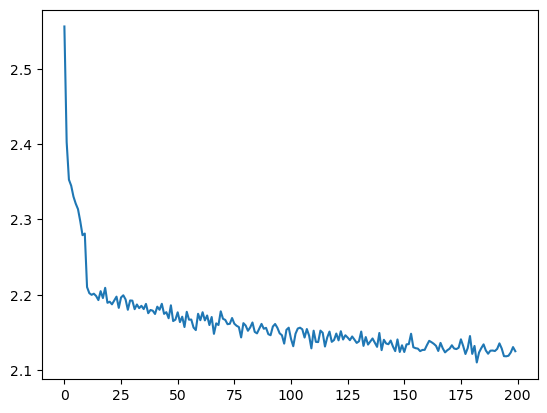

In [33]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1, keepdim= True).data);

# Pytorchifying our code
Add `Embedding`, `Flatten` and `Sequential` Classes

## Classes Definitions

## `torch.nn.Embedding`.

### 1. **The Concept of Embeddings**:

Embeddings are a powerful tool in the world of deep learning, especially when dealing with categorical data, like words in a language. Instead of representing words or other categorical variables as discrete values (like integers), embeddings represent them as continuous vectors. These vectors capture more information and relationships between different words or categories.

### 2. **torch.nn.Embedding**:

`torch.nn.Embedding` is PyTorch's module to create an embedding layer. Essentially, it's a lookup table that maps from integer indices (representing specific words or categories) to dense vectors (their embeddings).

### 3. **Parameters**:

- **num_embeddings**: Total number of distinct categories/words.
  
- **embedding_dim**: The size of each embedding vector, i.e., the number of units each embedding should have.

### 4. **Why Use Embeddings?**:

- **Dimensionality Reduction**: One-hot encoded vectors can be massive (imagine a vector of length 50,000 for a moderate-sized vocabulary, with all zeros except for a single one). Embeddings condense this information into a much smaller dimension, like 300 for word embeddings.

- **Capture Relationships**: Embeddings are learned from data. This means that words or categories that have similar meanings or behaviors can have embeddings that are close to each other in the vector space.

- **Flexibility**: Embeddings can be fine-tuned during training. This means that as a model learns a task, it can also adjust the embeddings to capture any task-specific insights.

### 5. **Usage**:

An embedding layer is typically initialized with random weights and will learn an embedding for all the words in the training dataset. It is a flexible layer that can be used in a variety of ways, such as:

- **Pre-trained Embeddings**: Sometimes, embeddings are pre-trained on a larger dataset and then fine-tuned on a specific task. Word2Vec, GloVe, and FastText are popular pre-trained word embeddings.

- **Task-specific Embeddings**: For some tasks, it might be beneficial to let the embedding layer learn embeddings from scratch, tailored to the specific task.

### 6. **Under the Hood**:

At its core, an embedding layer is a weight matrix. The rows of this matrix correspond to each category's unique ID (like a word's ID), and the columns correspond to the embedding dimensions. When you "pass" an integer to this layer, it returns the corresponding row of the weight matrix. This operation is essentially a lookup, making it efficient.

### Conclusion:

`torch.nn.Embedding` provides an efficient and straightforward way to handle categorical data in neural networks. By converting discrete categorical values into continuous vectors, embeddings enable models to capture intricate relationships in the data and improve performance on a variety of tasks.

## `torch.nn.Flatten`.

### 1. **The Basic Idea**:

When working with neural networks, especially convolutional neural networks (CNNs), we often deal with multi-dimensional data (like images). After passing this data through several convolutional and pooling layers, we often want to use the resulting multi-dimensional feature maps in fully connected layers (dense layers). However, fully connected layers expect a 1D input. Here's where `torch.nn.Flatten` comes in: it's used to transform multi-dimensional data into a one-dimensional format.

### 2. **torch.nn.Flatten**:

`torch.nn.Flatten` is a layer provided by PyTorch that reshapes its input into a one-dimensional tensor. It's effectively a 'flattening' operation.

### 3. **Parameters**:

- **start_dim**: Dimension to start the flattening. Typically, for a batch of images, the data shape might be `[batch_size, channels, height, width]`. If we want to flatten the channel, height, and width dimensions, we'd start the flattening from dimension 1 (0-based indexing for dimensions). By default, `start_dim` is 1.

- **end_dim**: Dimension to end the flattening. By default, it's -1, meaning it will flatten all dimensions from `start_dim` to the last dimension.

### 4. **Why Use Flatten?**:

- **Transitioning in Architectures**: It's common in CNNs to have convolutional layers followed by dense layers. The flatten layer acts as a bridge between these two, reshaping the output of the convolutional layers to a format that dense layers can work with.

- **Simplicity**: Instead of manually reshaping tensors using `.view()` or `.reshape()`, `torch.nn.Flatten` provides a more readable and explicit way to flatten data within a model architecture.

### 5. **Usage**:

Imagine you have a batch of images with the shape `[batch_size, channels, height, width]`. After passing them through convolutional layers, you might get a shape like `[batch_size, 64, 7, 7]`. Before sending this to a fully connected layer, you'd use the flatten layer:

```python
flat_layer = torch.nn.Flatten()
flattened_data = flat_layer(conv_output)
```

Now, `flattened_data` will have a shape `[batch_size, 64*7*7]`, ready to be passed to a fully connected layer.

### 6. **In Context**:

If you're familiar with other deep learning frameworks, you might recognize this as similar to TensorFlow's `tf.keras.layers.Flatten` or Keras's `Flatten` layer. It's a staple in the toolkit of designing deep learning architectures.

### Conclusion:

`torch.nn.Flatten` is a utility layer in PyTorch that streamlines the process of converting multi-dimensional tensors into a one-dimensional format, easing the transition from convolutional layers to fully connected layers in neural network architectures. It's a straightforward yet crucial component for many deep learning models, particularly CNNs.

## `torch.nn.Sequential`.

### 1. **The Basic Idea**:

When building neural networks, we often create architectures that involve a series of layers or operations that process data in a specific order. `torch.nn.Sequential` is a container provided by PyTorch that allows us to encapsulate a sequence of modules or operations into a single module, streamlining both the definition and execution of such sequences.

### 2. **torch.nn.Sequential**:

At its core, `torch.nn.Sequential` is essentially an ordered container of modules. Data passed to a `Sequential` module will traverse through each contained module in the order they were added, with the output of one module becoming the input to the next.

### 3. **Advantages**:

- **Readability**: Architectures, especially simpler ones, become more readable and compact. Instead of defining and calling layers separately, you can consolidate them into a single `Sequential` block.
  
- **Modularity**: It allows for easy reuse of certain sequences of operations across different architectures. If a specific sequence of layers gets used frequently, encapsulating it within a `Sequential` block makes it easier to plug into various models.

### 4. **Usage**:

Suppose you're designing a simple feedforward neural network with two hidden layers and ReLU activations:

Without `Sequential`:
```python
self.fc1 = torch.nn.Linear(input_size, hidden_size)
self.relu1 = torch.nn.ReLU()
self.fc2 = torch.nn.Linear(hidden_size, hidden_size)
self.relu2 = torch.nn.ReLU()
self.fc3 = torch.nn.Linear(hidden_size, output_size)
```
With `Sequential`:
```python
self.layers = torch.nn.Sequential(
    torch.nn.Linear(input_size, hidden_size),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_size, hidden_size),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_size, output_size)
)
```

The latter is clearly more concise and readable.

### 5. **Points to Remember**:

- While `Sequential` is convenient, it's most suited for networks where the data flow is linear. For architectures with branches (like skip connections in ResNets) or multiple inputs/outputs, manual layer definition might be more appropriate.

- Modules in `Sequential` are executed in the order they're added, making the order crucial. Always ensure that layers are added in the intended sequence.

### 6. **In Context**:

If you're familiar with other deep learning frameworks, the concept might remind you of Keras's `Sequential` model. The idea of simplifying linear stacks of layers is a common one across various deep learning libraries, given its convenience.

### Conclusion:

`torch.nn.Sequential` is a convenient tool in the PyTorch library that helps in compactly defining and organizing linear sequences of operations in neural network architectures. While incredibly useful for straightforward, linear data flows, it's essential to remember its limitations when dealing with more complex architectures.

In [34]:
# Layers made in part 3
class Linear:
    def __init__(self, fan_in, fan_out, bias = True):
        self.weight = torch.randn((fan_in, fan_out))
        self.weight /= fan_in ** 0.5
        self.bias = torch.zeros((fan_out)) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum = 0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True

        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        # buffers (trained while running `momentum update`)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            # batch mean
            xmean = x.mean(0, keepdim= True)
            # batch variance
            xvar = x.var(0, keepdim= True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta

        # update the buffers in training
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []
    
# ---------------- new ----------------
class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))
    
    def __call__(self, x):
        self.out = self.weight[x]
        return self.out
    
    def parameters(self):
        return [self.weight]
    
class Flatten:
    def __call__(self, x):
        self.out = x.view((x.shape[0], -1))
        return self.out
    
    def parameters(self):
        return []

class Sequential:
    def __init__(self, layers):
        self.layers = layers
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)

        self.out = x
        return self.out

    def parameters(self):
        return [p for l in self.layers for p in l.parameters()]

## Initialize the model

In [35]:
n_embd = 10
n_hidden = 200

model = Sequential([
    Embedding(vocab_size, n_embd),
    Flatten(),

    Linear(n_embd * block_size, n_hidden, bias= False),
    BatchNorm1d(n_hidden),
    Tanh(),

    Linear(n_hidden, vocab_size)
])

with torch.no_grad():
    layers[-1].weight *= 0.1

parameters = model.parameters()
print(f"num parameters: {sum(p.numel() for p in parameters)}")
for p in parameters:
    p.requires_grad_()


num parameters: 12097


## Training the model

In [36]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
update_to_data_ratio = []

for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass is now simpler
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)

    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 10000 else 0.01
    for p in parameters:
        p.data -= lr * p.grad
    
    # track stats
    if i % 10000 == 0:
        print(f"step {i} loss {loss.item()}")

    lossi.append(loss.item())

step 0 loss 3.531754493713379


## Model Evaluation

In [37]:
for layer in model.layers:
    layer.training = False

In [38]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        "train": (Xtr, Ytr),
        "valid": (Xdev, Ydev),
        "test": (Xte, Yte)
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    return loss.item()

print("train", split_loss("train"))
print("valid", split_loss("valid"))

train 3.5045688152313232
valid 3.5048117637634277


## Sample from the model

In [39]:
# sampling from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        # Forward pass
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim = 1)

        ix = torch.multinomial(probs, num_samples = 1).item()

        # Shift the Context Window
        context = context[1:] + [ix]

        if ix == 0:
            break

        out.append(ix)
    
    print("".join(itos[i] for i in out))
        

qwzqafikobfomyqgly
jqrfohseadzjqkfgqxaipbfdsgv
wqf
oidazkdqzhiehjwnwfohppcgtyog
csugtawfuhifxaste
j
kqmgqxia
hiahmjcplgpedqivr
t
nnoxoxuuxccvktuku
iatuuxghlharqrfzxabcr
qlocpyradlmtkstjutwjunolzoflgiizsxtnlexesdcbk
ilgulzmehtfglvbafwqxuxxuycvtknohajlsgevrrbbqr
qjjflupnv
j
tiesaedmgwijkcmjcftflpebyfnrqeqix
gtibmpgexvpynncobkjpnbotjez
meqfiuhkejfcjvsigosxgzfhbbkqximglxzmlhvcw
qidzkdebwwbncdrbwgtatqntzrfshjeqsydqaeohghojkqnkpbldigvxzahljktlupscrthmazgmegwxzsidqjwkn
bteruejqewqhgiljpdanqpnkogvluvpyofsqitcjcfmtcrdlpxlcfdnrnpj


# Building the WaveNet Model

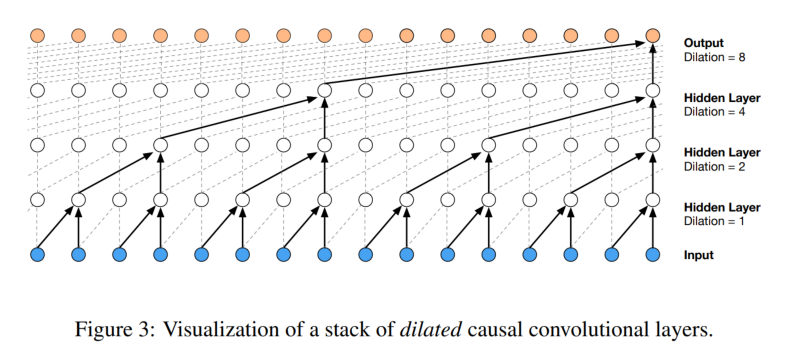

In [40]:
# preview an image
import matplotlib.pyplot as plt
plt.figure(figsize=(10,20))
plt.imshow(plt.imread("dilated_casual_conv.png"))
plt.axis("off");

## Changing Dataset blocksize

In [41]:
block_size = 8
def build_dataset(words):  

  X, Y = [], []
  
  for w in words:

    context = [0] * block_size
    for ch in w + '.':

      ix = stoi[ch]

      X.append(context)
      Y.append(ix)

      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182580, 8]) torch.Size([182580])
torch.Size([22767, 8]) torch.Size([22767])
torch.Size([22799, 8]) torch.Size([22799])


In [42]:
for x, y in zip(Xtr[:15], Ytr[:15]):
  print("".join(itos[ix.item()] for ix in x), "---->", itos[y.item()])

........ ----> e
.......e ----> b
......eb ----> r
.....ebr ----> i
....ebri ----> m
...ebrim ----> a
..ebrima ----> .
........ ----> h
.......h ----> i
......hi ----> l
.....hil ----> t
....hilt ----> o
...hilto ----> n
..hilton ----> .
........ ----> j


## Initializing a normal network

In [43]:
n_embd = 10
n_hidden = 200

model = Sequential([
    Embedding(vocab_size, n_embd),
    Flatten(),

    Linear(n_embd * block_size, n_hidden, bias= False),
    BatchNorm1d(n_hidden),
    Tanh(),

    Linear(n_hidden, vocab_size)
])

with torch.no_grad():
    layers[-1].weight *= 0.1

parameters = model.parameters()
print(f"num parameters: {sum(p.numel() for p in parameters)}")
for p in parameters:
    p.requires_grad_()


num parameters: 22097


## Implementing WaveNet

## Our model gets improved using ideas from Wavenet

The finished model is inspired by WaveNet, which is a deep learning architecture designed for generating raw audio waveforms.

**Innovation**:
1. **Hierarchical Fusion of Information**: Instead of squashing all the character information into a single layer right at the beginning, the new model aims for a more hierarchical approach. This is akin to WaveNet's methodology where information from previous contexts gets fused progressively as the network gets deeper. It's a departure from the original network that was more linear in its approach.
2. **FlattenConsecutive Layer**: This new layer is essentially reshaping the data by grouping consecutive embeddings, which helps in retaining more granularity of information for longer sequences.
3. **Increased Depth with Batch Normalization**: The model has added depth, with multiple hidden layers interspersed with BatchNorm layers. Batch Normalization helps in stabilizing and accelerating the training of deeper networks.

**Intuition**:
1. **Preserving Contextual Information**: By not immediately squashing all characters into a single layer, the network retains more of the raw, granular information from the input. This is crucial when predicting the next character based on a sequence of prior characters. The more original context the model has, the better its predictive capability.
2. **Progressive Fusion of Information**: Just as our human cognition processes information hierarchically (from letters to words to sentences to paragraphs), the model is designed to gradually combine information. It first understands pairs of characters, then bigger chunks, and so on. This allows the model to capture both short-term and long-term dependencies in the data.
3. **Stability with Batch Normalization**: Deep networks can suffer from internal covariate shift where the distribution of layer inputs changes during training. Batch normalization standardizes the inputs of a layer, making training more stable and faster.
4. **Embedding Layer**: It's a look-up table that maps from integer indices (representing specific words or characters) to dense vectors (their embeddings). These vectors are trainable and can capture the semantic relationship between words or characters. By using embeddings, the model can capture richer representations of the input data.

In summary, the hierarchical approach is inspired by WaveNet's methodology of processing audio signals, where the prediction for the next audio sample depends on a gradually fused context of previous samples. By applying a similar approach to character prediction, the model aims to capture richer contextual information, leading to better predictions.

## WaveNet Implementation and Tensor Management

### Forward Pass Visualization
The lecturer is working on a neural network implementation of WaveNet. To ensure understanding and correct functioning, they visualize the forward pass by observing tensor shapes at each stage. This helps in understanding data transformations as it progresses through the network.

### Input Batch and Shape
A batch of 4 random examples is created for debugging. The shape of the batch (referred to as \( xB \)) is \($ 4 \times 8 $\) due to having 4 examples and a block size of 8.

### Embedding Layer
The first layer is the embedding layer. When the integer tensor \( xB \) is passed through this layer, the output shape becomes \( $4 \times 8 \times 10 $\). Here, each character has a 10-dimensional vector representation. The embedding layer takes the integers and converts them into these 10-dimensional vectors.

### Flattening and Concatenation
The flattened layer views the \( $4 \times 8 \times 10 $\) tensor as a \( $4 \times 80 $\) tensor. The effect is that the 10-dimensional embeddings for the 8 characters are lined up in a row, appearing as if they've been concatenated.

### Linear Layer and Matrix Multiplication
The linear layer is responsible for transforming the shape from \( $4 \times 80 $\) to \($ 4 \times 200$ \). This is achieved through matrix multiplication. The lecturer emphasizes that in PyTorch, the matrix multiplication operator is versatile and can handle higher-dimensional tensors, treating earlier dimensions as batch dimensions.

### Restructuring Input
A key insight is that instead of flattening the entire input, we can group and process parts of it. For instance, the lecturer suggests grouping every two consecutive elements for processing in parallel. This results in a tensor shape of \($ 4 \times 4 \times 20 $\).

### Flattening Consecutively
To achieve the desired restructuring, the lecturer introduces a new method called "Flatten Consecutive". This method differs from the regular flattening by allowing for flattening only a specified number of consecutive elements, leading to multi-dimensional outputs rather than fully flattened ones.

### Model Layers and Parameter Count
The lecturer moves on to demonstrate how the neural network layers are organized. They ensure that the number of parameters remains consistent as the model architecture evolves, emphasizing the importance of maintaining model capacity.

### WaveNet's Performance
After restructuring the neural network, the lecturer observes that the validation loss remains nearly identical to the original, simpler model. This suggests that, at least in this instance, the added complexity doesn't yield performance benefits.

### Potential Issues with BatchNorm1D
The lecturer points out that while the model runs, there might still be issues, specifically with the BatchNorm1D layer. A thorough review of this layer is necessary to ensure it's functioning correctly.

### Shape Exploration

In [44]:
# look at batch of 5 examples (it's 4 in the original video but I changed it to 5 to prevent confusion)
ix = torch.randint(0, Xtr.shape[0], (5,))
Xb, Yb = Xtr[ix], Ytr[ix]

logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([5, 8])


tensor([[ 0, 19,  1, 14, 20,  9, 14, 15],
        [ 0,  0,  0,  0, 26,  1, 13,  9],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0, 16,  5],
        [ 0,  0,  0,  0,  0, 14,  1,  8]])

## Update Embedding Layer

### 1. **Current Model State**:
The current model has training and validation losses that are close to each other. This suggests that the model isn't overfitting. In such cases, a common approach to improve performance is to expand the model: increase its capacity by adding more neurons or layers.

### 2. **Problem with Current Architecture**:
Right now, the model takes in a sequence of characters, processes them through a single layer, and predicts the next character. This is somewhat akin to trying to understand a sentence by reading all its words at once. While you can add more layers, you're still compressing all the information at the very beginning, which might be suboptimal.

### 3. **Inspiration from WaveNet**:
WaveNet offers a different approach. Instead of compressing all characters at once, it processes the input in a hierarchical manner. Imagine trying to understand a sentence not word by word, but by understanding two words at a time, then four words, then eight, and so on. This allows the model to capture relationships and patterns at different scales.

### 4. **Progressive Fusion**:
The key idea is to combine (or "fuse") input data progressively. Start by combining pairs of characters (bigrams). Then, combine pairs of bigrams to form four-character chunks, and so on. This slow fusion ensures that the model has a more refined understanding of the input data at various levels of granularity.

### 5. **Dilated Causal Convolutions**:
While it sounds complex, the core idea is about efficiency and preserving information. In standard convolutions, each layer can only see a limited portion of the input. By using dilated convolutions, each layer can see a wider range of input, allowing the model to capture longer-term dependencies without needing extremely deep architectures. The "causal" part ensures that the prediction at any time step is only based on past and current data, not future data.

### Conclusion:
In essence, the lecturer is suggesting moving from a simplistic model that quickly compresses input information to a more sophisticated architecture that understands the input in a layered and hierarchical manner. This approach, inspired by WaveNet, allows the model to capture patterns and relationships at different scales, potentially leading to better performance. The implementation details, like dilated causal convolutions, are there to ensure efficiency and respect the temporal nature of the data.

In [45]:
for layer in model.layers:
    print(f"{layer.__class__.__name__} has output size of: {layer.out.shape}")

Embedding has output size of: torch.Size([5, 8, 10])
Flatten has output size of: torch.Size([5, 80])
Linear has output size of: torch.Size([5, 200])
BatchNorm1d has output size of: torch.Size([5, 200])
Tanh has output size of: torch.Size([5, 200])
Linear has output size of: torch.Size([5, 27])


We don't want to process the 8 characters at the same time
```
1 2 3 4 5 6 7 8
```
But we want to process them in 4 groups of 2 characters in parallel
```
(1 2) (3 4) (5 6) (7 8)
```

So instead of multiplying `(5, 80) @ (80, 200) = (5, 200)` we want to multiply `(5, 4, 20) @ (20, 200) = (5, 4, 200)`

In [46]:
# output of layer 0
e = torch.randn(5, 8, 10)
# contacenate even and odd (on character dimension) elements of the last dimension
explicit = torch.cat([e[:, ::2, :], e[:, 1::2, :]], dim = 2)
# you can do the same using view
implicit = e.view(5, 4, 20)

(implicit == explicit).all()

tensor(True)

### FlattenConsectutive Class

## `torch.squeeze`

The `torch.squeeze` function removes dimensions of size 1 from a tensor. It's particularly useful when certain operations introduce unwanted singleton dimensions, and you want to revert back to a more compact shape.

**Function signature**:
```python
torch.squeeze(input, dim=None, *, out=None)
```

- `input` (Tensor): The input tensor.
- `dim` (int, optional): Specifies which dimension to squeeze. If not specified, all dimensions of size 1 will be squeezed.
- `out` (Tensor, optional): The output tensor.

### **Examples**:

1. **Squeezing all dimensions of size 1**:

```python
import torch

# A tensor with shape [1, 3, 1, 2]
x = torch.tensor([[[[1, 2]], [[3, 4]], [[5, 6]]]])
print(x.shape)  # torch.Size([1, 3, 1, 2])

y = torch.squeeze(x)
print(y.shape)  # torch.Size([3, 2])
```

Here, `torch.squeeze` removed the first and third dimensions, both of size 1.

2. **Squeezing a specific dimension**:

If you only want to squeeze a specific dimension, you can specify it using the `dim` argument.

```python
z = torch.squeeze(x, dim=0)
print(z.shape)  # torch.Size([3, 1, 2])
```

In this case, only the first dimension of size 1 was squeezed.

3. **A tensor with no dimensions of size 1**:

```python
a = torch.tensor([[1, 2], [3, 4]])
print(a.shape)  # torch.Size([2, 2])

b = torch.squeeze(a)
print(b.shape)  # torch.Size([2, 2])
```

As there were no dimensions of size 1, `torch.squeeze` had no effect on the tensor's shape.

### **Note**:

Be cautious when using `torch.squeeze` without specifying a dimension. In some cases, especially when your tensor might sometimes have singleton dimensions due to variable data sizes (e.g., batch size of 1 in deep learning models), unintended squeezing might lead to shape mismatches or other errors in subsequent operations.

In [47]:
# Reimplement Flatten
class FlattenConsecutive:
    def __init__(self, n):
        # n is the number of consecutive elements we want (2 in our example)
        self.n = n
    
    def __call__(self, x):
        # in our example: B = 5, T = 8, C = 10
        B, T, C = x.shape
        # we want to convert X to (5, 4, 20)
        x = x.view(B, T // self.n, C * self.n)

        if x.shape[1] == 1:
            x = x.squeeze(1)
        
        self.out = x
        return self.out

    def parameters(self):
        return []

### Previous behavior using FlattenConsecutive

In [48]:
n_embd = 10
n_hidden = 200

model = Sequential([
    Embedding(vocab_size, n_embd),
    # calling FlattenConsecutive(block_size) will return in the same previous behavior
    FlattenConsecutive(block_size),

    Linear(n_embd * block_size, n_hidden, bias= False),
    BatchNorm1d(n_hidden),
    Tanh(),

    Linear(n_hidden, vocab_size)
])

with torch.no_grad():
    layers[-1].weight *= 0.1

parameters = model.parameters()
print(f"num parameters: {sum(p.numel() for p in parameters)}")
for p in parameters:
    p.requires_grad_()


num parameters: 22097


In [49]:
ix = torch.randint(0, Xtr.shape[0], (5,))
Xb, Yb = Xtr[ix], Ytr[ix]

logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([5, 8])


tensor([[ 0,  0,  3,  1, 18, 18,  9,  3],
        [ 0,  0,  0, 19, 20,  1, 18, 18],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0, 11,  1, 12,  5, 20],
        [ 0,  0,  0,  4,  1, 25, 12,  5]])

In [50]:
for layer in model.layers:
    print(f"{layer.__class__.__name__} has output size of: {(layer.out.shape)}")

Embedding has output size of: torch.Size([5, 8, 10])
FlattenConsecutive has output size of: torch.Size([5, 80])
Linear has output size of: torch.Size([5, 200])
BatchNorm1d has output size of: torch.Size([5, 200])
Tanh has output size of: torch.Size([5, 200])
Linear has output size of: torch.Size([5, 27])


### Processing Hierarchically: FlattenConsecutive(2)

In [51]:
n_embd = 10
# changing the number of hidden units to 68 keeps the same number of parameters as the previous model (22k)
n_hidden = 68

model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias= False), BatchNorm1d(n_hidden),Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias= False), BatchNorm1d(n_hidden),Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias= False), BatchNorm1d(n_hidden),Tanh(),
    Linear(n_hidden, vocab_size),
])

with torch.no_grad():
    layers[-1].weight *= 0.1

parameters = model.parameters()
print(f"num parameters: {sum(p.numel() for p in parameters)}")
for p in parameters:
    p.requires_grad_()

num parameters: 22397


In [52]:
ix = torch.randint(0, Xtr.shape[0], (5,))
Xb, Yb = Xtr[ix], Ytr[ix]

logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([5, 8])


tensor([[ 0,  0,  0,  0,  0,  0, 13,  5],
        [ 0,  0,  0,  0,  0, 14,  9, 19],
        [ 0,  0,  1,  9, 25,  1, 14, 14],
        [ 0,  0,  0,  0, 25, 15, 21, 19],
        [ 0,  0,  0,  0,  0,  0,  0,  4]])

In [53]:
for layer in model.layers:
    print(f"{layer.__class__.__name__} has output size of: {layer.out.shape}")

Embedding has output size of: torch.Size([5, 8, 10])
FlattenConsecutive has output size of: torch.Size([5, 4, 20])
Linear has output size of: torch.Size([5, 4, 68])
BatchNorm1d has output size of: torch.Size([5, 4, 68])
Tanh has output size of: torch.Size([5, 4, 68])
FlattenConsecutive has output size of: torch.Size([5, 2, 136])
Linear has output size of: torch.Size([5, 2, 68])
BatchNorm1d has output size of: torch.Size([5, 2, 68])
Tanh has output size of: torch.Size([5, 2, 68])
FlattenConsecutive has output size of: torch.Size([5, 136])
Linear has output size of: torch.Size([5, 68])
BatchNorm1d has output size of: torch.Size([5, 68])
Tanh has output size of: torch.Size([5, 68])
Linear has output size of: torch.Size([5, 27])


however, this network gives the same loss = 2.0

### Fixing BatchNorm Bug

We implemented batchnorm for X 2D only. We calculated mean and variance for the first dimension only. We don't want to average over the batch dimension only, but also over the 2nd dimension (the 4 groups of 2 characters)

- **Issue**: The current BatchNorm1D implementation assumes a two-dimensional input, but the actual input is three-dimensional. This discrepancy leads to improper calculations.
- **Current Behavior**: The BatchNorm receives an input with dimensions 32x4x68. Although this shape allows the code to run without errors due to broadcasting, it doesn't work as intended.
- **Desired Behavior**: The BatchNorm should be modified to consider both the zeroth and first dimensions as batch dimensions. Instead of averaging over 32 numbers, the average should be over \($32 \times 4$\) numbers for each of the 68 channels.
- **Solution**: The lecturer suggests using the `torch.mean` function, which can reduce over multiple dimensions at the same time. By passing in a tuple (0,1) as dimensions, the mean is calculated over both the zeroth and first dimensions, leading to a 1x1x68 shape.

## Deviation from PyTorch API

There's a highlighted difference between the lecturer's implementation and PyTorch's BatchNorm1D:

- **PyTorch's BatchNorm1D**: Assumes that when input is three-dimensional, it should be in the form of nxCxL (with C being the number of features or channels).
- **Lecturer's Implementation**: Assumes the input to be in the form of nxLxC.

## Development Process of Building Deep Neural Nets

1. **Reference to Documentation**: It's essential to frequently refer to the documentation to understand the various layers, their expected input shapes, and functionalities. However, the lecturer notes that PyTorch documentation can sometimes be misleading or incomplete.
2. **Shape Management**: A significant amount of time is spent ensuring tensor shapes are compatible. This involves reshaping tensors, understanding expected input and output shapes, and sometimes prototyping to ensure shapes align.
3. **Prototyping**: The lecturer emphasizes the utility of Jupyter notebooks for prototyping. Once satisfied with the prototype, the code is transferred to a more permanent codebase.
4. **Use of Convolutions**: Convolutions are introduced as a means for efficiency. Instead of processing inputs individually, convolutions allow the model to process multiple inputs simultaneously by sliding filters over the input sequence. This concept connects with future topics, like Convolutional Neural Networks (CNNs).

In [54]:
e = torch.rand(32, 4, 68)
emean = e.mean(dim = (0,1), keepdim = True) # (1, 1, 68)
evar = e.var((0,1), keepdim = True) # (1, 1, 68)
ehat = (e - emean) / torch.sqrt(evar + 1e-5)

print(ehat.shape)
print(f"shape of running mean is {model.layers[3].running_mean.shape}")

torch.Size([32, 4, 68])
shape of running mean is torch.Size([1, 4, 68])


In [55]:
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum = 0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True

        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        # buffers (trained while running `momentum update`)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            # determine the dimension to reduce over
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0,1)
            
            xmean = x.mean(dim, keepdim= True)
            # batch variance
            xvar = x.var(dim, keepdim= True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta

        # update the buffers in training
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

In [56]:
n_embd = 10
# changing the number of hidden units to 68 keeps the same number of parameters as the previous model (22k)
n_hidden = 68

model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias= False), BatchNorm1d(n_hidden),Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias= False), BatchNorm1d(n_hidden),Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias= False), BatchNorm1d(n_hidden),Tanh(),
    Linear(n_hidden, vocab_size),
])

with torch.no_grad():
    layers[-1].weight *= 0.1

parameters = model.parameters()
print(f"num parameters: {sum(p.numel() for p in parameters)}")
for p in parameters:
    p.requires_grad_()

num parameters: 22397


## Improving WaveNet's Performance

- **Current Performance**: The model's performance has improved from a loss of 2.1 to 1.993.
- **Challenges**: The lecturer points out that the current approach lacks an experimental harness, meaning they're mostly making educated guesses without a systematic way to evaluate changes.
- **Potential Improvements**: Suggestions include re-allocating channels, tweaking the number of dimensions for embeddings, or even reverting to a simpler network structure. The WaveNet paper itself might also have additional strategies or layers worth implementing.

# Final Implementation

In [57]:
# Layers made in part 3
class Linear:
    def __init__(self, fan_in, fan_out, bias = True):
        self.weight = torch.randn((fan_in, fan_out))
        self.weight /= fan_in ** 0.5
        self.bias = torch.zeros((fan_out)) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum = 0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True

        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        # buffers (trained while running `momentum update`)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            # determine the dimension to reduce over
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0,1)
            
            xmean = x.mean(dim, keepdim= True)
            # batch variance
            xvar = x.var(dim, keepdim= True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta

        # update the buffers in training
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []
    

class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))
    
    def __call__(self, x):
        self.out = self.weight[x]
        return self.out
    
    def parameters(self):
        return [self.weight]
    
class Flatten:
    def __call__(self, x):
        self.out = x.view((x.shape[0], -1))
        return self.out
    
    def parameters(self):
        return []

class Sequential:
    def __init__(self, layers):
        self.layers = layers
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)

        self.out = x
        return self.out

    def parameters(self):
        return [p for l in self.layers for p in l.parameters()]

class FlattenConsecutive:
    def __init__(self, n):
        # n is the number of consecutive elements we want (2 in our example)
        self.n = n
    
    def __call__(self, x):
        # in our example: B = 5, T = 8, C = 10
        B, T, C = x.shape
        # we want to convert X to (5, 4, 20)
        x = x.view(B, T // self.n, C * self.n)

        if x.shape[1] == 1:
            x = x.squeeze(1)
        
        self.out = x
        return self.out

    def parameters(self):
        return []

In [58]:
n_embd = 24 
n_hidden = 128 

model = Sequential([
  Embedding(vocab_size, n_embd),
  FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size),
])

with torch.no_grad():
  model.layers[-1].weight *= 0.1 # last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

76579


In [59]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update: simple SGD
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.2952
  10000/ 200000: 2.2564
  20000/ 200000: 2.0685
  30000/ 200000: 2.0009
  40000/ 200000: 2.3341
  50000/ 200000: 2.2683
  60000/ 200000: 1.9244
  70000/ 200000: 1.9783
  80000/ 200000: 1.6898
  90000/ 200000: 1.7922
 100000/ 200000: 1.8421
 110000/ 200000: 1.5324
 120000/ 200000: 1.9049
 130000/ 200000: 1.5367
 140000/ 200000: 1.8640
 150000/ 200000: 1.7453
 160000/ 200000: 1.5165
 170000/ 200000: 2.0527
 180000/ 200000: 1.6559
 190000/ 200000: 1.5118


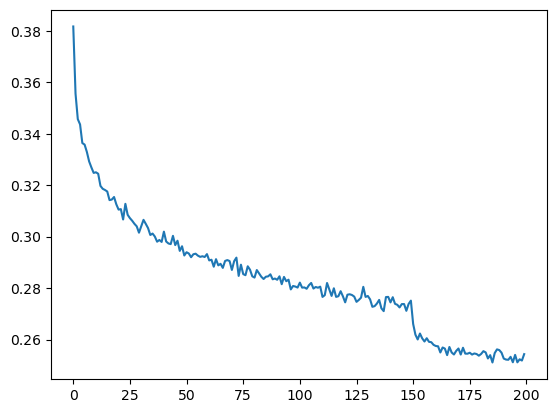

In [60]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1, keepdim= True).data);

In [61]:
for layer in model.layers:
    layer.training = False

In [62]:
print("train", split_loss("train"))
print("valid", split_loss("valid"))

train 1.7711992263793945
valid 1.9916445016860962


In [63]:
# sampling from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        # Forward pass
        logits = model(torch.tensor([context]).reshape(1, -1))
        probs = F.softmax(logits, dim = 1)

        ix = torch.multinomial(probs, num_samples = 1).item()

        # Shift the Context Window
        context = context[1:] + [ix]

        if ix == 0:
            break

        out.append(ix)
    
    print("".join(itos[i] for i in out))

khyron
yanifs
jesiel
kahlani
culeymarah
romy
zitarah
zephary
haralynn
suaiya
alazia
kristian
shadheil
zarie
emmahna
devaya
leidy
delalie
takarose
railine


Validation loss becomes 1.993

In [64]:
#| hide
import nbdev; nbdev.nbdev_export()